<a href="https://colab.research.google.com/github/vimalthomas/Databricks-GenAI-Series/blob/main/MLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from typing import Tuple


def batch_generator(train_x, train_y, batch_size):
    indices = np.arange(len(train_x))
    np.random.shuffle(indices)  # Shuffle indices

    for i in range(0, len(train_x), batch_size):
        batch_idx = indices[i:i+batch_size]
        batch_x = train_x[batch_idx]
        batch_y = train_y[batch_idx]
        yield batch_x, batch_y






class ActivationFunction(ABC):
    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the output of the activation function, evaluated on x

        Input args may differ in the case of softmax

        :param x (np.ndarray): input
        :return: output of the activation function
        """
        pass

    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the derivative of the activation function, evaluated on x
        :param x (np.ndarray): input
        :return: activation function's derivative at x
        """
        pass


class Sigmoid(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x) * (1 - self.forward(x))




class Tanh(ActivationFunction):
    pass


class Relu(ActivationFunction):
  def forward(self, x: np.ndarray) -> np.ndarray:
    return np.maximum(0, x)  # ReLU function: max(0, x)

  def derivative(self, x: np.ndarray) -> np.ndarray:
    return (x > 0).astype(float)  # Derivative: 1 for x > 0, else 0



class Softmax(ActivationFunction):
    pass


class Linear(ActivationFunction):
    pass


class LossFunction(ABC):
    @abstractmethod
    def loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        pass


class SquaredError(LossFunction):
    def loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return 1/2 * np.square(y_pred-y_true)

    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return (y_pred - y_true)/y_pred.shape[0]


class CrossEntropy(LossFunction):
    def loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:

        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:

        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -y_true / y_pred

class BinaryCrossEntropy(LossFunction):
    def loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        Computes binary cross-entropy loss
        """
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # Prevent log(0) issues
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        Computes gradient of binary cross-entropy loss
        """
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return (y_pred - y_true) / (y_pred * (1 - y_pred) * len(y_true))



class Layer:
    def __init__(self, fan_in: int, fan_out: int, activation_function: ActivationFunction):
        """
        Initializes a layer of neurons

        :param fan_in: number of neurons in previous (presynpatic) layer
        :param fan_out: number of neurons in this layer
        :param activation_function: instance of an ActivationFunction
        """
        self.fan_in = fan_in
        self.fan_out = fan_out
        self.activation_function = activation_function

        # this will store the activations (forward prop)
        self.activations = None
        # this will store the delta term (dL_dPhi, backward prop)
        self.delta = None

        # Initialize weights and biaes
        # self.W = None  # weights
        # self.b = None  # biases

        #note to self. looks like He initialization will help relu function
        #come back later

        #self.W = np.random.randn(fan_in, fan_out) * 0.01
        self.W = np.random.randn(fan_in, fan_out) * np.sqrt(2.0 / fan_in)  # He_init for Relu

        self.b = np.zeros((fan_out,))

    def forward(self, h: np.ndarray):
        """
        Computes the activations for this layer

        :param h: input to layer
        :return: layer activations
        """
        #Z calculation

        Z = np.dot(h, self.W) + self.b
        #self.activations = None
        self.activations = self.activation_function.forward(Z)
        return self.activations




    # def backward(self, h: np.ndarray, delta: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    #     """
    #     Apply backpropagation to this layer and return the weight and bias gradients

    #     :param h: input to this layer
    #     :param delta: delta term from layer above
    #     :return: (weight gradients, bias gradients)
    #     """

    #     #compute dZ
    #     dZ = delta * self.activation_function.derivative(self.activations)
    #     #compute dW, db

    #     dL_dW = np.dot(h.T, dZ) / h.shape[0]
    #     dL_db = np.sum(dZ, axis=0) / h.shape[0]


    #     self.delta = dZ
    #     return dL_dW, dL_db

    def backward(self, h: np.ndarray, delta: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
      """

      Apply backpropagation to this layer and return the weight and bias gradients.

      :param h: Input to this layer.
      :param delta: Delta term from the layer above.
      :return: (Weight gradients, Bias gradients).
      """

      # Compute dZ
      dZ = delta * self.activation_function.derivative(self.activations)

    # Compute weight and bias gradients
      dL_dW = np.dot(h.T, dZ) / h.shape[0]  # (fan_in, fan_out)
      dL_db = np.sum(dZ, axis=0, keepdims=True) / h.shape[0]  # (1, fan_out)

    # Convert to NumPy array (ensures no list issue)
      dL_db = np.array(dL_db)

    # Correctly propagate `self.delta`
      self.delta = np.dot(dZ, self.W.T)  # (batch_size, fan_in)

      return dL_dW, dL_db



class MultilayerPerceptron:
    def __init__(self, layers: Tuple[Layer]):
        """
        Create a multilayer perceptron (densely connected multilayer neural network)
        :param layers: list or Tuple of layers
        """
        self.layers = layers

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        This takes the network input and computes the network output (forward propagation)
        :param x: network input
        :return: network output
        """

        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, loss_grad: np.ndarray, input_data: np.ndarray) -> Tuple[list, list]:


      """
      Applies backpropagation to compute gradients of weights and biases for all layers in the network.

      :param loss_grad: Gradient of loss w.r.t. final layer output (dL/dA).
      :param input_data: The input data to the network (train_x for the first layer).
      :return: (List of weight gradients for all layers, List of bias gradients for all layers).
      """

      dl_dw_all = []
      dl_db_all = []

      dL_dA = loss_grad  # Start with gradient from the loss function

    # Iterate backward through layers
      for i in reversed(range(len(self.layers))):
        layer = self.layers[i]

        # Get the correct input for this layer
        if i == 0:
            h = input_data  # First layer gets train_x
        else:
            h = self.layers[i - 1].activations  # Other layers get activations from previous layer

        # Compute backpropagation step for this layer
        dL_dW, dL_db = layer.backward(h, dL_dA)

        # Store gradients
        dl_dw_all.append(dL_dW)
        dl_db_all.append(dL_db)

        dL_dA = layer.delta

    # Reverse lists to match layer order
      dl_dw_all.reverse()
      dl_db_all.reverse()

      return dl_dw_all, dl_db_all














    def train(self, train_x: np.ndarray, train_y: np.ndarray, val_x: np.ndarray, val_y: np.ndarray, loss_func: LossFunction, learning_rate: float=1E-3, batch_size: int=16, epochs: int=32) -> Tuple[np.ndarray, np.ndarray]:
        """
        Train the multilayer perceptron

        :param train_x: full training set input of shape (n x d) n = number of samples, d = number of features
        :param train_y: full training set output of shape (n x q) n = number of samples, q = number of outputs per sample
        :param val_x: full validation set input
        :param val_y: full validation set output
        :param loss_func: instance of a LossFunction
        :param learning_rate: learning rate for parameter updates
        :param batch_size: size of each batch
        :param epochs: number of epochs
        :return:
        """

        #define the epoch loop

        training_losses = []
        validation_losses = []


        #defin epoch loop

        for epoch in range(epochs):

          #define batch loop
          total_loss = 0

          for batch_x, batch_y in batch_generator(train_x, train_y, batch_size):


            #forward pass
            y_pred = self.forward(batch_x)

            #compute loss

            batchloss = loss_func.loss(batch_y, y_pred)
            total_loss = total_loss + np.mean(batchloss)

            #print(total_loss)


            #backward pass and compute gradianet
            #dL_dW, dL_db  = self.backward(loss_func.derivative(batch_y, output), batch_x)
            dL_dW, dL_db  = self.backward(loss_func.derivative(batch_y[:len(y_pred)], y_pred), batch_x)


            #update weights
            max_grad_norm = 1.0  # Limits the maximum gradient value



            for i in range(len(self.layers)):
              # Clip gradients
              dL_dW[i] = np.clip(dL_dW[i], -max_grad_norm, max_grad_norm)
              dL_db[i] = np.clip(dL_db[i], -max_grad_norm, max_grad_norm)

              self.layers[i].W -= learning_rate * dL_dW[i]
              #self.layers[i].b -= learning_rate * dL_db[i]
              self.layers[i].b -= learning_rate * np.array(dL_db[i]).flatten()




          training_losses.append(total_loss / len(train_x))

          # Compute Validation Loss
          val_output = self.forward(val_x)
          val_loss = loss_func.loss(val_y, val_output)
          validation_losses.append(np.mean(val_loss))

          # Compute training accuracy at the end of the epoch
          train_acc = compute_accuracy(self, train_x, train_y)
          val_acc = compute_accuracy(self, val_x, val_y)

          print(f"dL_dW max: {np.max([np.max(w) for w in dL_dW])}, min: {np.min([np.min(w) for w in dL_dW])}")
          print(f"dL_db max: {np.max([np.max(b) for b in dL_db])}, min: {np.min([np.min(b) for b in dL_db])}")

          print(f"Epoch {epoch+1}/{epochs} - Training Loss: {total_loss:.4f} - Training Acc: {train_acc:.2f}% - Validation Acc: {val_acc:.2f}% - Validation Loss: {validation_losses[-1]:.4f}")








        return training_losses, validation_losses

def compute_accuracy(model, X, y):
    """
    Compute accuracy of the model.

    :param model: The trained MLP model
    :param X: Input features (numpy array)
    :param y: True labels (numpy array)
    :return: Accuracy in percentage (%)
    """
    y_pred = model.forward(X)  # Forward pass
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to 0 or 1
    accuracy = np.mean(y_pred_binary == y) * 100  # Compute accuracy

    return accuracy

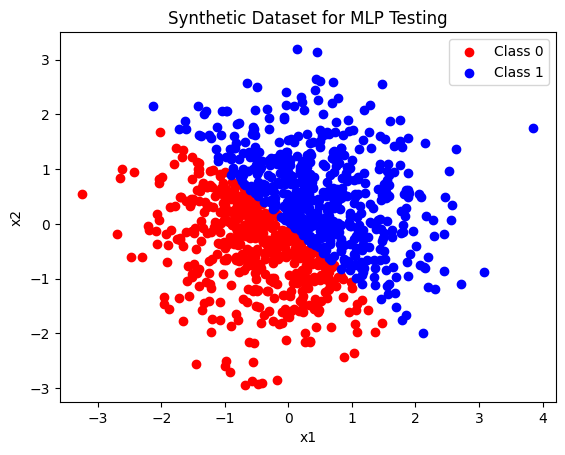

Class distribution: {0: 382, 1: 418}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
num_samples = 1000

# Features: x1 and x2 sampled from normal distribution
x1 = np.random.randn(num_samples)
x2 = np.random.randn(num_samples)

# Labels: 1 if x1 + x2 > 0, else 0
y = (x1 + x2 > 0).astype(int)

# Stack features into input matrix
X = np.column_stack((x1, x2))
Y = y.reshape(-1, 1)  # Convert to column vector

# Split into train and validation sets
split = int(0.8 * num_samples)
train_x, val_x = X[:split], X[split:]
train_y, val_y = Y[:split], Y[split:]

# Plot the dataset
plt.scatter(x1[y == 0], x2[y == 0], color='red', label='Class 0')
plt.scatter(x1[y == 1], x2[y == 1], color='blue', label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Synthetic Dataset for MLP Testing')
plt.legend()
plt.show()

unique, counts = np.unique(train_y, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")


In [ ]:
# Create an MLP model
layers = [
    Layer(fan_in=2, fan_out=4, activation_function=Relu()),  # Hidden layer with 4 neurons
    Layer(fan_in=4, fan_out=1, activation_function=Sigmoid()) # Output layer with 1 neuron
]

mlp = MultilayerPerceptron(layers)

# Train the model
loss_function = BinaryCrossEntropy()
train_losses, val_losses = mlp.train(
    train_x=train_x, train_y=train_y,
    val_x=val_x, val_y=val_y,
    loss_func=loss_function,
    learning_rate=0.0001, batch_size=16, epochs=50
)


dL_dW max: 0.3184400368047219, min: -0.3836425181273385
dL_db max: 0.18306559596850025, min: -0.0924706791171065
Epoch 1/50 - Training Loss: 45.6385 - Training Acc: 63.75% - Validation Acc: 68.50% - Validation Loss: 0.8444
dL_dW max: 0.1302693016855814, min: -0.09078762910494484
dL_db max: 0.06974364529536098, min: -0.03608565202062438
Epoch 2/50 - Training Loss: 45.5716 - Training Acc: 63.75% - Validation Acc: 68.50% - Validation Loss: 0.8433
dL_dW max: 0.36136984940125394, min: -0.40822503355289885
dL_db max: 0.15120851254487108, min: -0.06792447029557269
Epoch 3/50 - Training Loss: 45.5105 - Training Acc: 64.00% - Validation Acc: 68.50% - Validation Loss: 0.8423
dL_dW max: 0.5341613567956268, min: -0.4667361627876038
dL_db max: 0.18960206986398126, min: -0.0973702966365013
Epoch 4/50 - Training Loss: 45.4434 - Training Acc: 64.00% - Validation Acc: 68.50% - Validation Loss: 0.8412
dL_dW max: 0.385151592073846, min: -0.5355597910406348
dL_db max: 0.1830794369418169, min: -0.085687545